# Comparison of different renewal processes inferred Rt profiles

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel,  cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 2

In [2]:
# # Read contact matrix
# cm_file = 'UK'
# path = os.path.join('../data_library/contact_matrix', '{}.csv'.format(cm_file))
# contact_matrix = pd.read_csv(path, header=None)

# # Read serial interval
# si_file = 'si-epinow'
# path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
# serial_interval = pd.read_csv(path, header=None)
# serial_interval = serial_interval.fillna(0)
# serial_intervals = serial_interval.values.T

# # Read transmissibility vector
# trans_file = 'UK'
# path = os.path.join('../data_library/transmissibility', '{}.csv'.format(trans_file))
# transmissibility = pd.read_csv(path, header=None)

In [3]:
# # Read Ontario data
# path = os.path.join('../data_library/covid_ontario/ON.csv')
# data = pd.read_csv(path)[:51]

# Data Set 1

## Parameterize example branching process model with disagregated data

In [4]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[1, 0.5], [0.3, 0.4]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [0.5, 1.2]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 50] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[0.]
 [0.]] [[50. 50.]]
[[0.24209583 0.        ]
 [0.24209583 0.        ]] [[50. 50.]
 [ 0.  0.]]
[[0.30586784 0.24209583 0.        ]
 [0.30586784 0.24209583 0.        ]] [[50. 50.]
 [ 0.  0.]
 [39. 27.]]
[[0.21709387 0.30586784 0.24209583 0.        ]
 [0.21709387 0.30586784 0.24209583 0.        ]] [[50. 50.]
 [ 0.  0.]
 [39. 27.]
 [56. 27.]]
[[0.12168272 0.21709387 0.30586784 0.24209583 0.        ]
 [0.12168272 0.21709387 0.30586784 0.24209583 0.        ]] [[50. 50.]
 [ 0.  0.]
 [39. 27.]
 [56. 27.]
 [75. 34.]]
[[0.05992779 0.12168272 0.21709387 0.30586784 0.24209583 0.        ]
 [0.05992779 0.12168272 0.21709387 0.30586784 0.24209583 0.        ]] [[50. 50.]
 [ 0.  0.]
 [39. 27.]
 [56. 27.]
 [75. 34.]
 [98. 46.]]
[[0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]
 [0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]]
[[0.01166356 0.027

## Plot agreggated local incidence numbers

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [6]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

[[0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]
 [0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]]
[[0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]
 [0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]]
[[0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]
 [0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]
 [149.  75.]]
[[0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]
 [0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]] [[ 50. 

In [7]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

[[0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]
 [0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]]
[[0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]
 [0.02719514 0.05992779 0.12168272 0.21709387 0.30586784 0.24209583
  0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]]
[[0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]
 [0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]] [[ 50.  50.]
 [  0.   0.]
 [ 39.  27.]
 [ 56.  27.]
 [ 75.  34.]
 [ 98.  46.]
 [109.  52.]
 [149.  75.]]
[[0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]
 [0.01166356 0.02719514 0.05992779 0.12168272 0.21709387 0.30586784
  0.24209583 0.        ]] [[ 50. 

In [8]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

### Desaggregated data + Poisson Branching process with multiple categories

In [9]:
multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_28053/4092849573.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [10]:
posterior = stan.build(
    multicat_model, data=multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   3.044  0.111   2.838    3.250      0.001    0.001    6920.0    2141.0   
R[1]   3.100  0.090   2.930    3.265      0.001    0.001    6628.0    2098.0   
R[2]   3.057  0.083   2.898    3.212      0.001    0.001    7514.0    2205.0   
R[3]   3.022  0.074   2.879    3.156      0.001    0.001    7674.0    1806.0   
R[4]   2.984  0.060   2.878    3.099      0.001    0.000    7201.0    2354.0   
R[5]   2.963  0.056   2.851    3.064      0.001    0.000    7315.0    2210.0   
R[6]   2.966  0.048   2.878    3.054      0.001    0.000    7611.0    1865.0   
R[7]   2.987  0.042   2.908    3.065      0.000    0.000    7150.0    1902.0   
R[8]   3.007  0.037   2.936    3.078      0.000    0.000    7014.0    2190.0   
R[9]   2.332  0.030   2.276    2.389      0.000    0.000    5768.0    1372.0   
R[10]  1.803  0.021   1.761    1.842      0.000    0.000    7553.0    2240.0   
R[11]  1.469  0.019   1.433    1.505      0.000    0.000    8210.0    1947.0   
R[12]  1.237  0.016   1.208    1.271      0.000    0.000    7228.0    2143.0   
R[13]  1.036  0.015   1.010    1.066      0.000    0.000    8300.0    2028.0   
R[14]  0.805  0.013   0.782    0.830      0.000    0.000    8685.0    1939.0   
R[15]  0.497  0.011   0.476    0.516      0.000    0.000    6847.0    2026.0   
R[16]  0.504  0.011   0.483    0.525      0.000    0.000    7059.0    2336.0   
R[17]  0.506  0.013   0.482    0.530      0.000    0.000    8833.0    1884.0   
R[18]  0.520  0.014   0.494    0.545      0.000    0.000    6863.0    2378.0   
R[19]  0.529  0.016   0.500    0.561      0.000    0.000    7848.0    2416.0   
R[20]  0.533  0.018   0.501    0.569      0.000    0.000    7170.0    1980.0   
R[21]  0.545  0.020   0.508    0.583      0.000    0.000    5599.0    2169.0   
R[22]  0.541  0.023   0.496    0.584      0.000    0.000    7252.0    2040.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

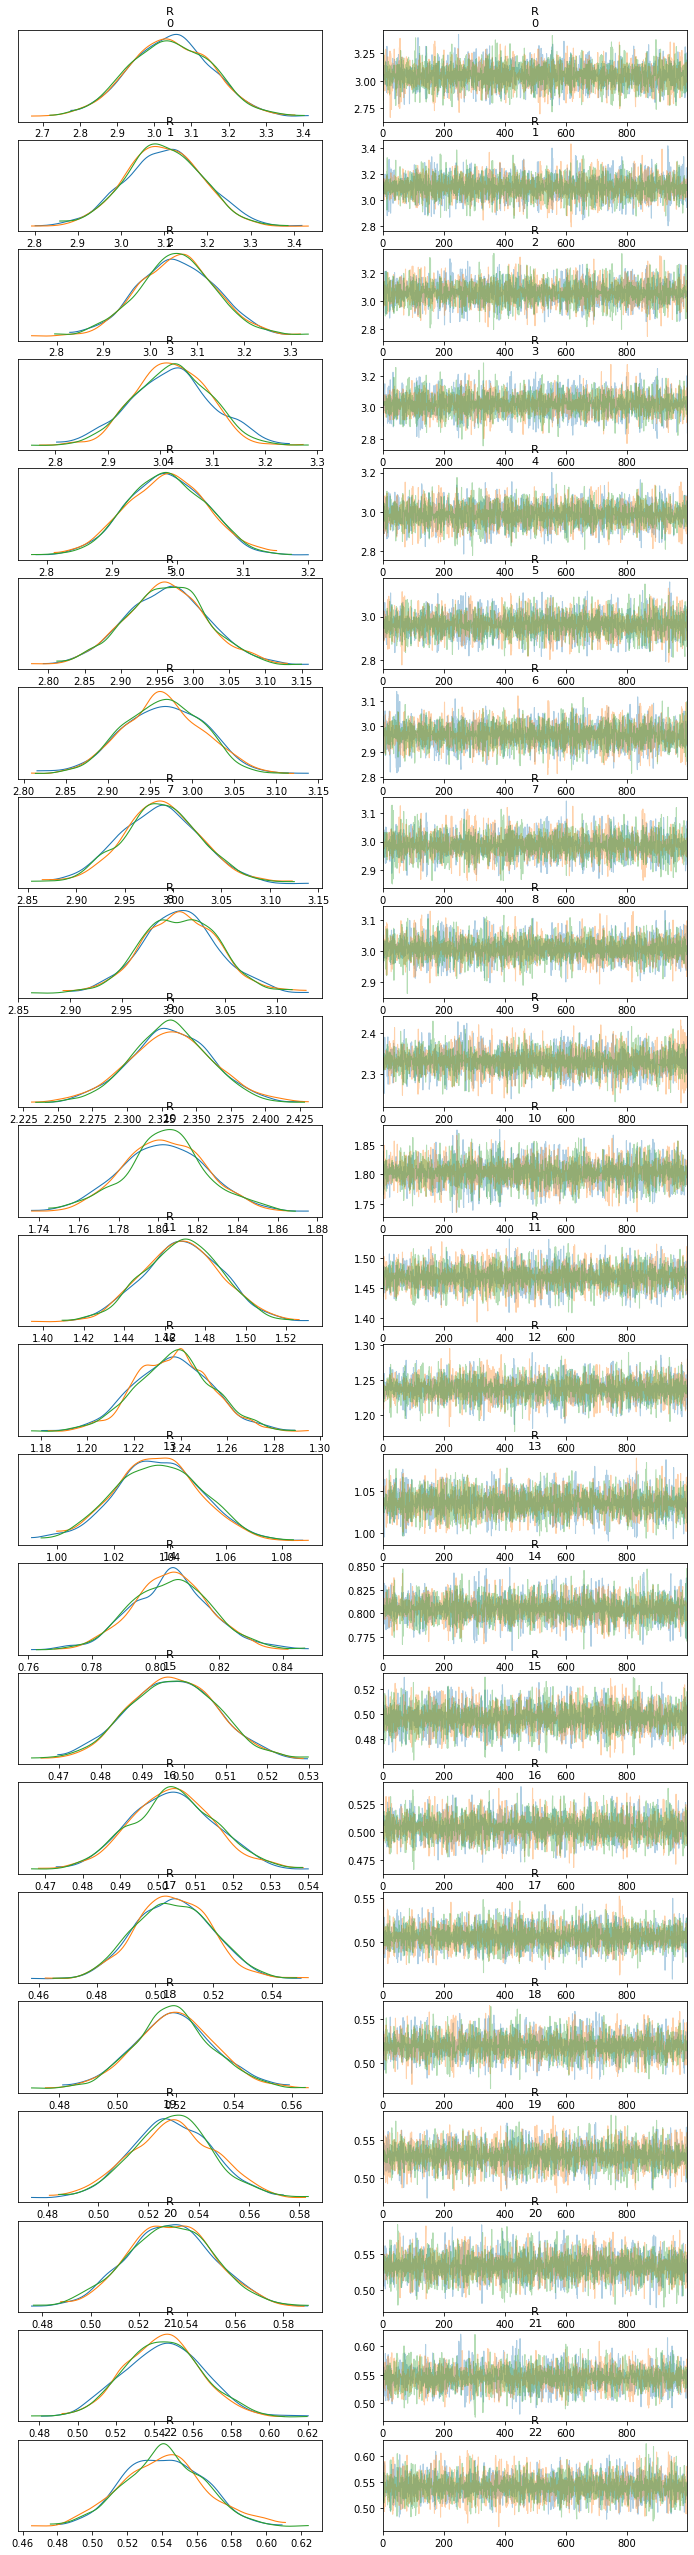

In [11]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [12]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process with multiple categories

In [13]:
agg_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int t, array [] real aI, array [] real aSI,
        array [,] real C, array [] real transm, array [] vector ap) {
            real mean;

            mean = 0;
            for(i in 1:n){
                for(j in 1:n){
                    if(t > S) {
                        for(k in (t-S):(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                    else {
                        for(k in 1:(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    simplex [n] p[N]; // vector of proportion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, n, k, I, revSI, C, transm, p) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, n, k, I, revSI, C, transm, p)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    for(t in 1:N) {
        p[t] ~ dirichlet (rep_vector(1, n)); // prior for p
    }
}
"""

agg_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_28053/1251656915.py:73: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [14]:
posterior = stan.build(
    agg_multicat_model, data=agg_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate'],
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 46, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 51, column 12: A
    control flow statement depends on parameter(s): p.
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 21, column 24: A
    control flow statement inside function effective_no_infectives depends on
    argument t. At
    '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan',
    line 54, column 33 to column 34, the value of t depends on parameter(s):
    p.
Warn

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]      2.412  0.091   2.249    2.585      0.001    0.001    5571.0   
R[1]      2.430  0.078   2.278    2.571      0.001    0.001    4181.0   
R[2]      2.364  0.069   2.235    2.492      0.001    0.001    5058.0   
R[3]      2.300  0.059   2.193    2.413      0.001    0.001    4823.0   
R[4]      2.245  0.048   2.154    2.337      0.001    0.000    5238.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[27, 1]  0.444  0.286   0.001    0.918      0.003    0.003    6925.0   
p[28, 0]  0.493  0.285   0.026    0.950      0.003    0.003    6166.0   
p[28, 1]  0.507  0.285   0.050    0.974      0.003    0.003    6166.0   
p[29, 0]  0.506  0.291   0.001    0.938      0.004    0.003    5737.0   
p[29, 1]  0.494  0.291   0.062    0.999      0.004    0.003    5737.0   

          ess_tail  r_hat  
R[0]        2403.0    1.0  
R[1]        2193.0    1.0  
R[2]        2341.0    1.0  
R[3]        2044.0    1.0  
R[4]        2315.0    1.0  
...            ...    ...  
p[27, 1]    1671.0    1.0  
p[28, 0]    2086.0    1.0  
p[28, 1]    2086.0    1.0  
p[29, 0]    2007.0    1.0  
p[29, 1]    2007.0    1.0  

[83 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

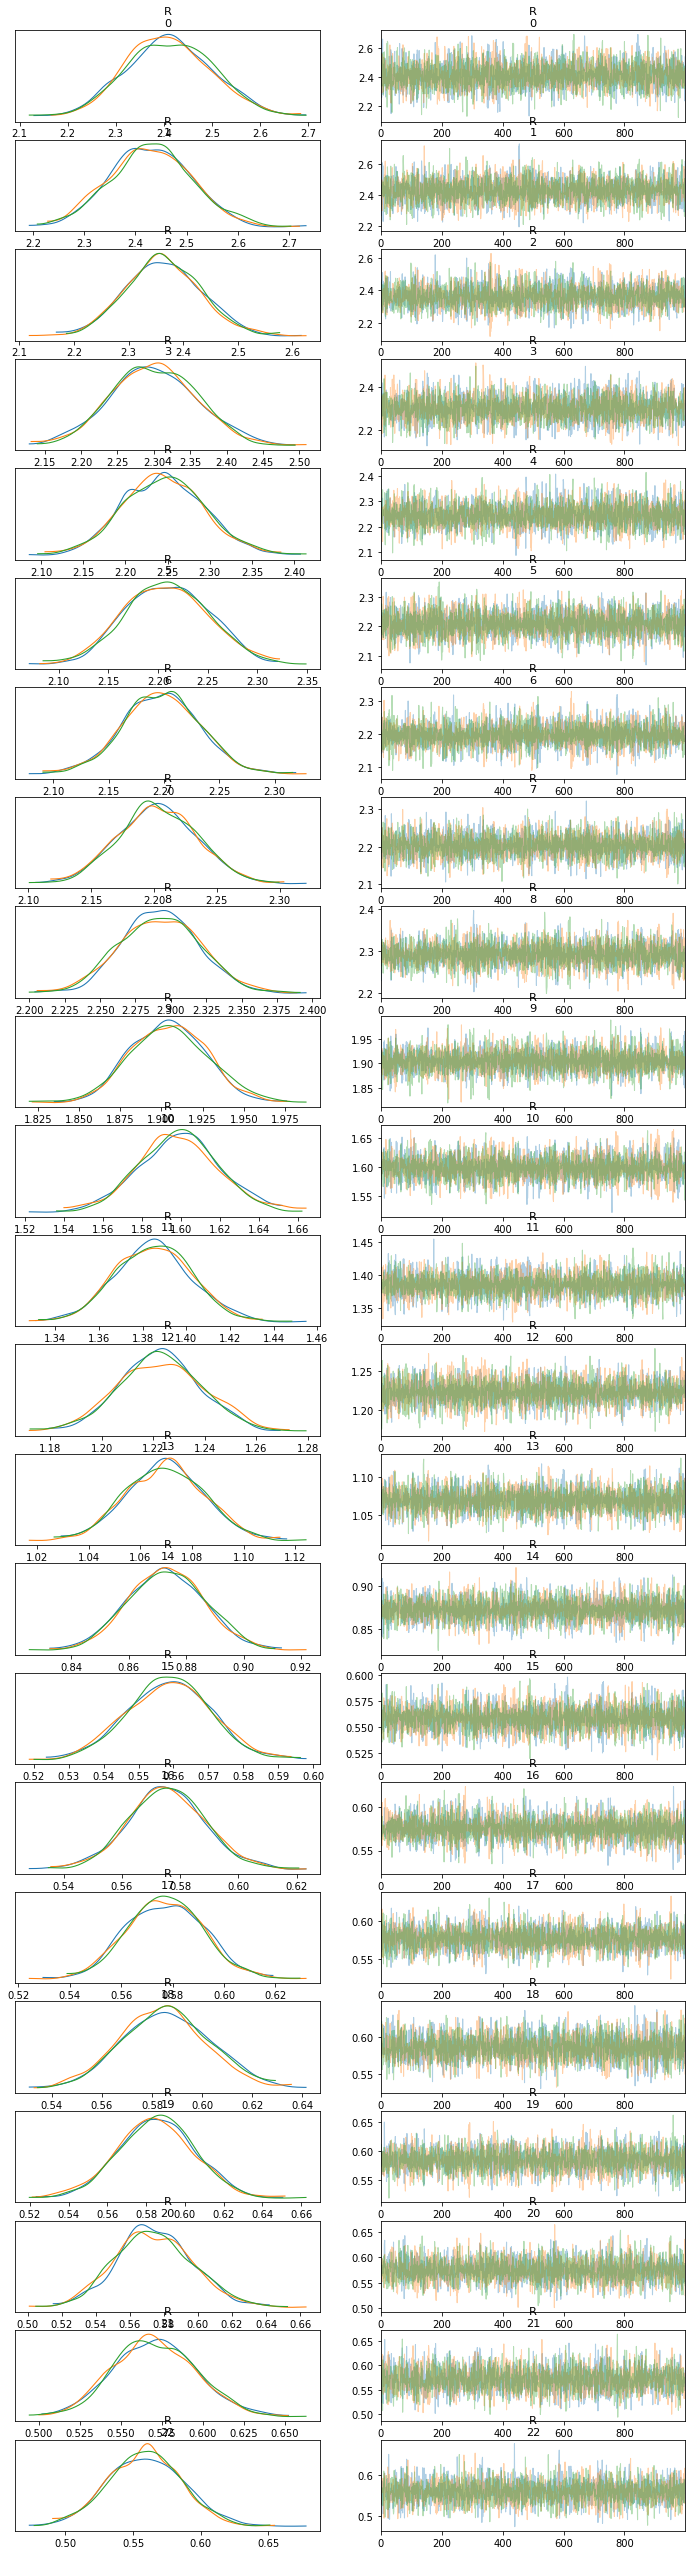

In [15]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

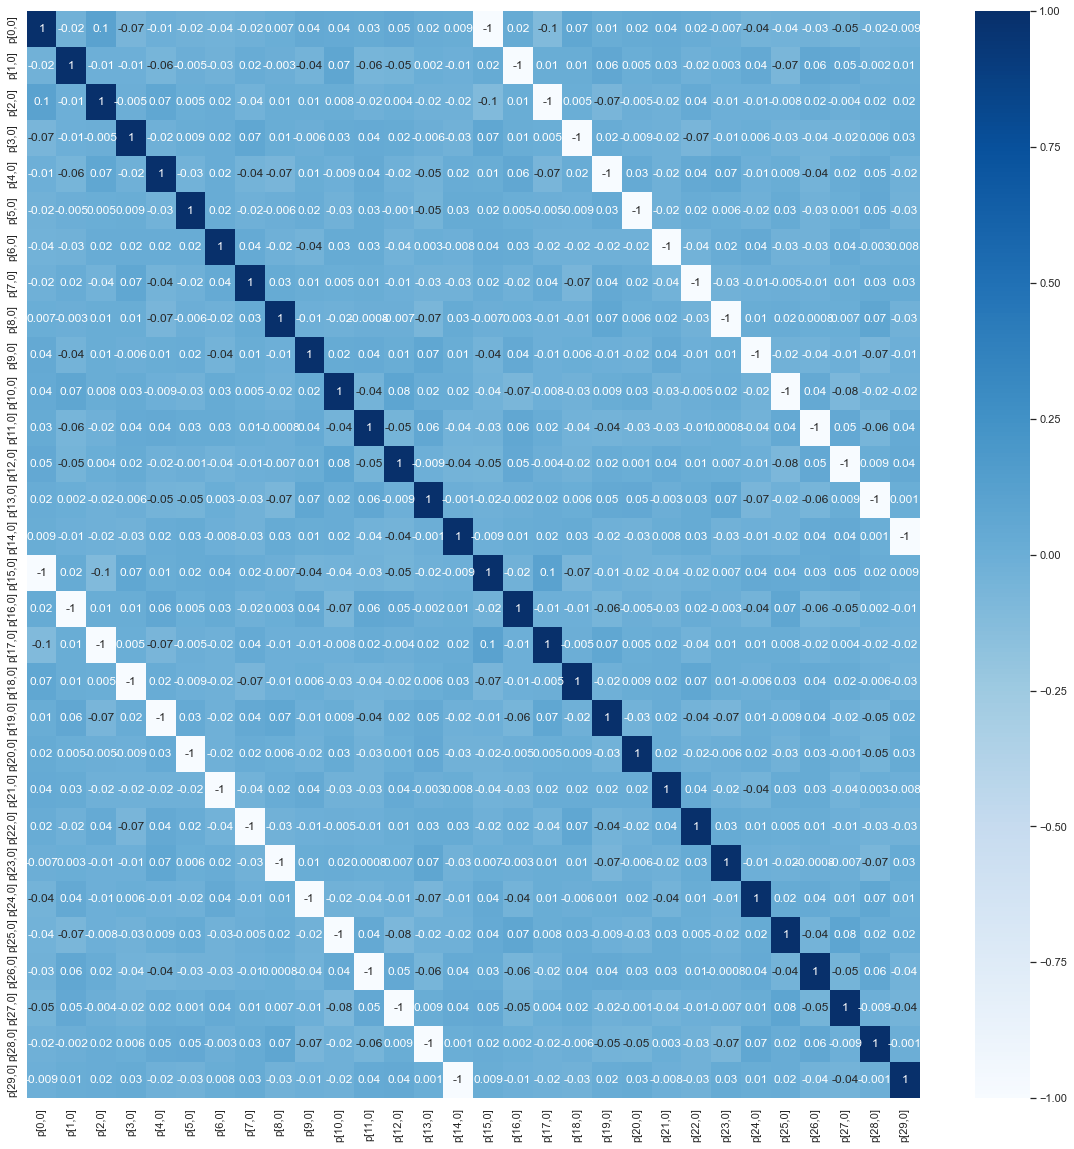

In [16]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
p_chain_samples = fit._draws[(num_timepoints - R_t_start +7)::num_categories, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = p_chain_samples.shape

extended_p_samples = np.concatenate((
    p_chain_samples[:, :, 0],
    p_chain_samples[:, :, 1],
    p_chain_samples[:, :, 2]), axis=1)

df = pd.DataFrame(
    np.transpose(extended_p_samples),
    columns=[
        'p[{},0]'.format(_)
        for _ in range(num_timepoints)])

plt.figure(figsize=(20,20))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:(num_timepoints - R_t_start +7), 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

agg_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process

In [18]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_28053/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [19]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   5% (301/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1500/6000)
Sampling:  28% (1700/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  38% (2300/6000)
Sampling:  42% (2500/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001152 seconds
  1000 transitions using 10 leapfrog steps per transition would take 11.52 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is a

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   2.493  0.089   2.314    2.654      0.001    0.001    6577.0    2184.0   
R[1]   2.512  0.074   2.380    2.656      0.001    0.001    6650.0    2028.0   
R[2]   2.454  0.066   2.331    2.579      0.001    0.001    6197.0    2145.0   
R[3]   2.403  0.055   2.302    2.501      0.001    0.000    7490.0    2161.0   
R[4]   2.362  0.048   2.278    2.455      0.001    0.000    6624.0    2186.0   
R[5]   2.340  0.043   2.258    2.418      0.000    0.000    7771.0    2204.0   
R[6]   2.344  0.039   2.272    2.417      0.000    0.000    6987.0    2287.0   
R[7]   2.363  0.033   2.301    2.425      0.000    0.000    6782.0    2045.0   
R[8]   2.376  0.028   2.320    2.428      0.000    0.000    6458.0    2144.0   
R[9]   1.842  0.023   1.802    1.885      0.000    0.000    7165.0    1849.0   
R[10]  1.425  0.017   1.390    1.455      0.000    0.000    6865.0    2433.0   
R[11]  1.160  0.014   1.132    1.186      0.000    0.000    7214.0    2101.0   
R[12]  0.976  0.012   0.954    1.000      0.000    0.000    6437.0    2351.0   
R[13]  0.816  0.011   0.794    0.836      0.000    0.000    5342.0    1605.0   
R[14]  0.634  0.010   0.615    0.652      0.000    0.000    7894.0    1888.0   
R[15]  0.391  0.008   0.376    0.406      0.000    0.000    6627.0    2026.0   
R[16]  0.396  0.009   0.380    0.412      0.000    0.000    6798.0    2312.0   
R[17]  0.396  0.010   0.377    0.413      0.000    0.000    7570.0    1624.0   
R[18]  0.406  0.011   0.387    0.426      0.000    0.000    7371.0    2163.0   
R[19]  0.413  0.013   0.390    0.437      0.000    0.000    8179.0    2362.0   
R[20]  0.416  0.015   0.390    0.444      0.000    0.000    6700.0    2320.0   
R[21]  0.426  0.016   0.395    0.457      0.000    0.000    8125.0    2198.0   
R[22]  0.424  0.019   0.389    0.458      0.000    0.000    6186.0    2041.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

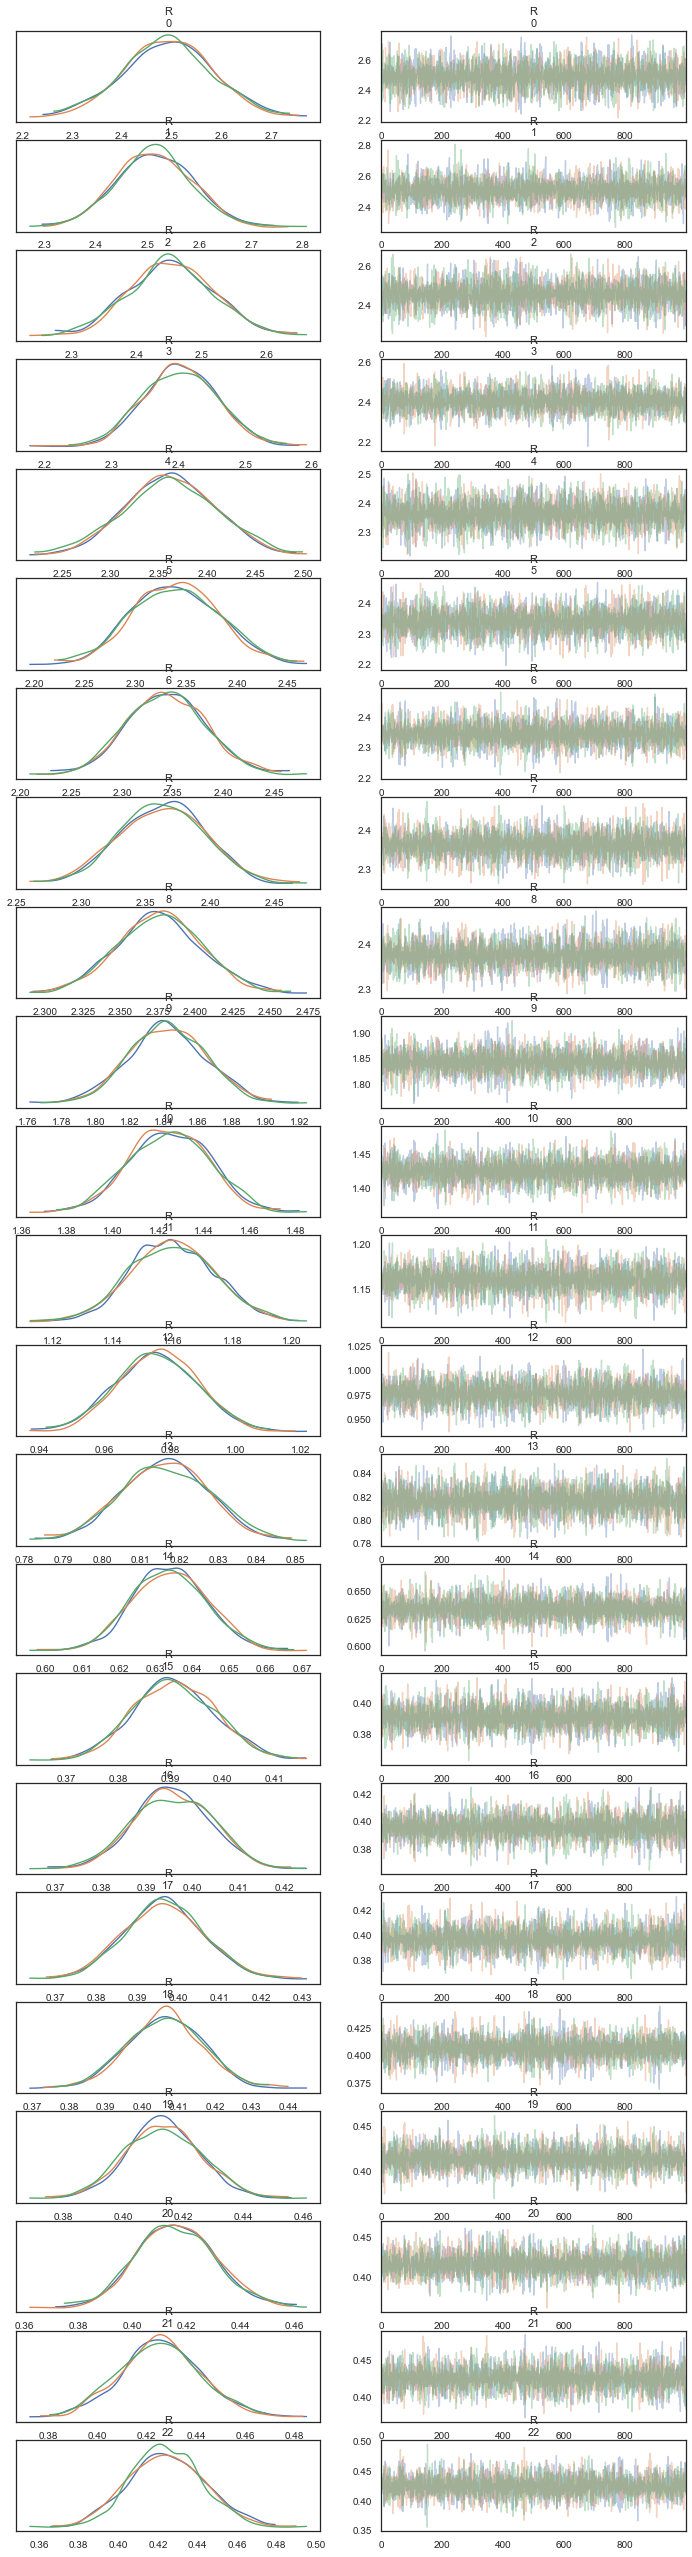

In [20]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [21]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1)/N_corr,
    'Central Probability': (L1+L2) * [0.95]
})

T_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[:, ::thinning], axis=1), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.025, axis=1), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.975, axis=1), T_corr),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Negative Binomial Branching process

In [22]:
negbin_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
    real phiShape; // prior shape parameter for phi
    real phiRate; // prior rate parameter for phi
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    real<lower=0> Phi; // overdispersion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ neg_binomial (1/Phi, 1/(Phi *
                    (R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)))); // likelihood
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    Phi ~ gamma (phiShape, phiRate); // prior of Phi
}
"""

negbin_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma,
    'phiShape': phi_shape,
    'phiRate': phi_rate}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_28053/3120966940.py:58: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [23]:
posterior = stan.build(
    negbin_model, data=negbin_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000)
Sampling:  13% (800/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient e

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   2.718  0.515   1.836    3.654      0.008    0.006    5453.0    2345.0   
R[1]   2.684  0.442   1.887    3.485      0.006    0.005    5640.0    2303.0   
R[2]   2.636  0.435   1.884    3.481      0.006    0.005    4886.0    2228.0   
R[3]   2.582  0.446   1.812    3.418      0.007    0.005    5374.0    2206.0   
R[4]   2.495  0.428   1.710    3.277      0.007    0.005    5006.0    1806.0   
R[5]   2.439  0.411   1.677    3.165      0.006    0.004    5009.0    2287.0   
R[6]   2.462  0.434   1.715    3.331      0.006    0.004    7026.0    1902.0   
R[7]   2.468  0.413   1.728    3.210      0.006    0.005    4648.0    2280.0   
R[8]   2.457  0.423   1.732    3.256      0.007    0.005    4345.0    2152.0   
R[9]   2.164  0.362   1.541    2.830      0.005    0.004    5696.0    2395.0   
R[10]  1.876  0.315   1.360    2.497      0.005    0.004    5377.0    2299.0   
R[11]  1.592  0.260   1.150    2.102      0.004    0.003    4268.0    2198.0   
R[12]  1.307  0.225   0.902    1.725      0.003    0.002    6104.0    2065.0   
R[13]  1.022  0.175   0.707    1.346      0.003    0.002    4078.0    2126.0   
R[14]  0.723  0.131   0.499    0.965      0.002    0.001    5386.0    2099.0   
R[15]  0.416  0.074   0.283    0.556      0.001    0.001    5183.0    2213.0   
R[16]  0.425  0.070   0.289    0.551      0.001    0.001    5412.0    2399.0   
R[17]  0.424  0.072   0.301    0.559      0.001    0.001    5083.0    1986.0   
R[18]  0.434  0.072   0.299    0.565      0.001    0.001    5269.0    2482.0   
R[19]  0.437  0.077   0.305    0.589      0.001    0.001    4776.0    2070.0   
R[20]  0.441  0.075   0.306    0.579      0.001    0.001    5066.0    2344.0   
R[21]  0.449  0.077   0.320    0.600      0.001    0.001    4623.0    2513.0   
R[22]  0.442  0.077   0.309    0.589      0.001    0.001    5491.0    2226.0   
Phi    0.186  0.022   0.146    0.225      0.000    0.000    3830.0    2494.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0  
Phi      1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

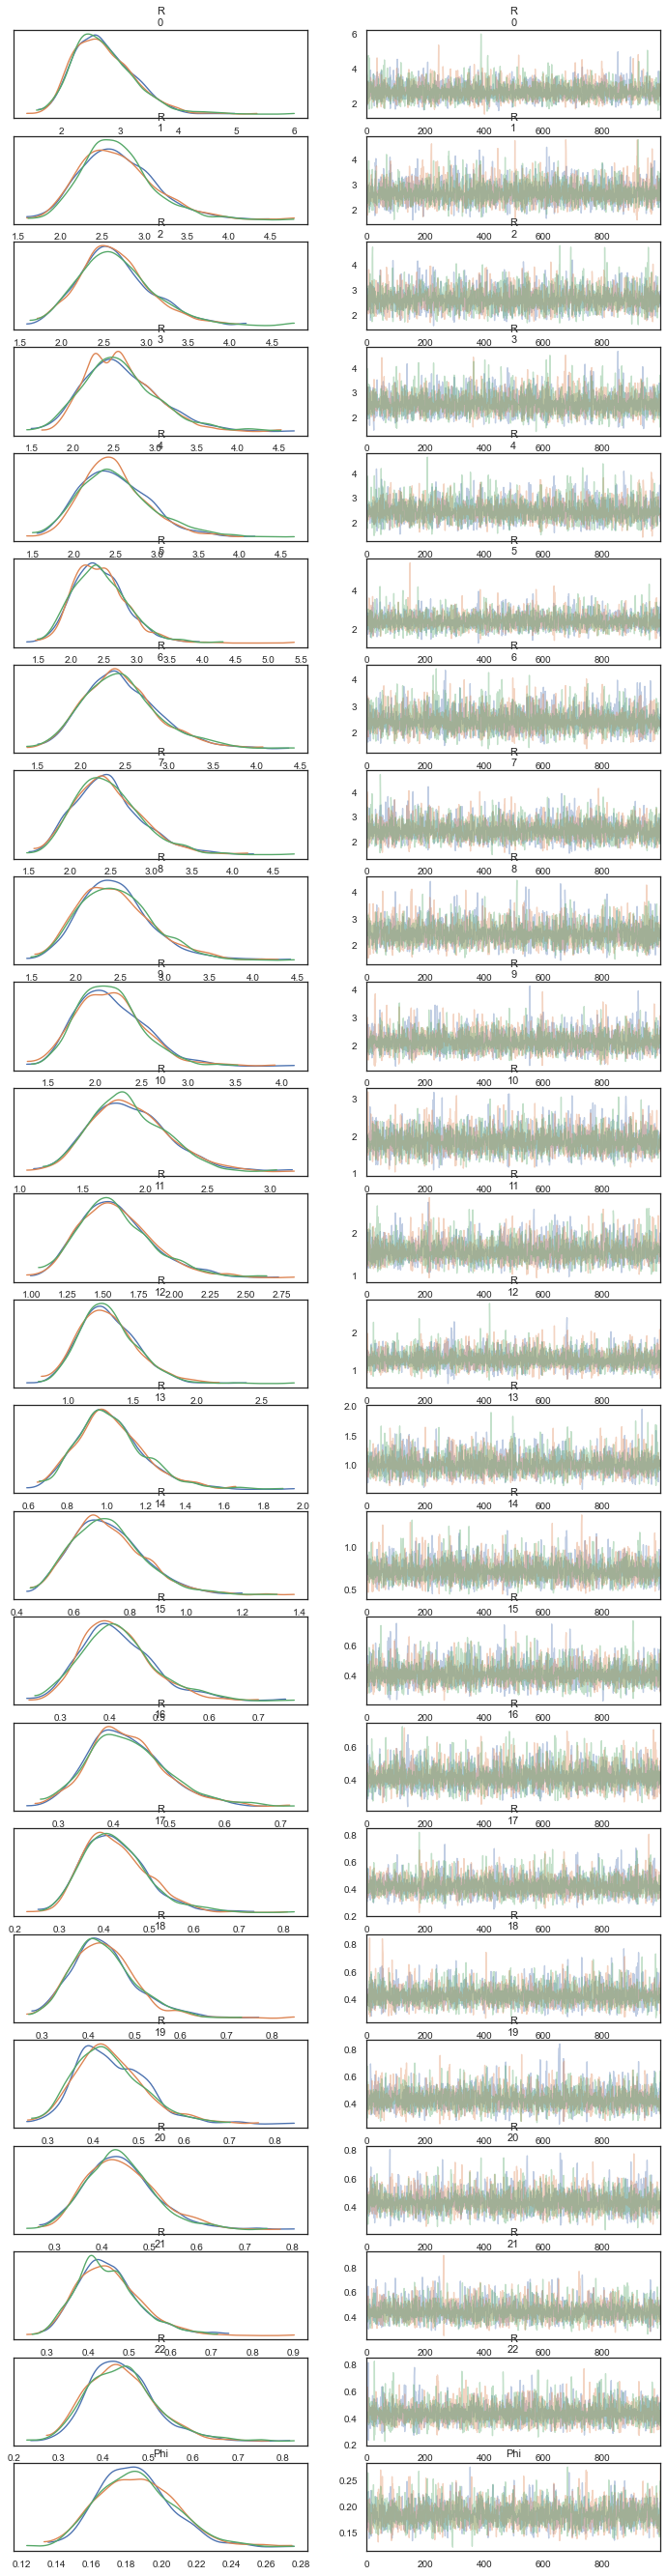

In [24]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start+1)

az.plot_trace(
    samples,
    var_names=('R', 'Phi'),
    filter_vars='like',
    compact=False)

In [25]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:-1, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1)/N_corr,
    'Central Probability': (L1+L2) * [0.95]
})

T_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[:, ::thinning], axis=1), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.025, axis=1), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.975, axis=1), T_corr),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [26]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(multicat_intervals, model_type='multi_categorical')
fig.add_interval_rt(agg_multicat_intervals, colour='orange', model_type='agg_multi_categorical')
fig.add_interval_rt(N_pois_intervals, colour='pink', shape='dash', model_type='poisson Naive correction term')
fig.add_interval_rt(T_pois_intervals, colour='red', model_type='poisson True correction term')
fig.add_interval_rt(N_negbin_intervals, colour='deepskyblue', shape='dash', model_type='negative_binomial Naive correction term')
fig.add_interval_rt(T_negbin_intervals, colour='blue', model_type='negative_binomial True correction term')

fig.update_labels(time_label='Time (Day)', r_label='Individual r_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

